In [1]:
from utils import test_train_split
from utils import LinearRegression, Metrics
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt, numpy as np, pandas as pd, random

In [2]:
orig_sale_price_df = pd.read_csv('AmesHousing_NumericalFeatures.csv')
norm_prod_df = pd.read_csv('AmesHousing_FirstProductHighCorrNormNumFeatures.csv') # after creating product features
norm_corr_df = pd.read_csv('AmesHousing_NumVars_Norm_Corr_Filtered_Log.csv') # before creating product features

In [3]:
print(len(orig_sale_price_df.columns)-1)

32


In [4]:
sale_prices = list(orig_sale_price_df['SalePrice'].values)
log_sale_prices = [np.log(sale_price) for sale_price in sale_prices]

max_sale_price = np.max(sale_prices)
max_log_sale_price = np.max(log_sale_prices)

In [5]:
def sale_price_from_norm_log_val(norm_log_val):
    
    ''' Recovers original dollar amount sale price 
        from normalized logarithm value.'''
    
    return np.exp(norm_log_val*max_log_sale_price)

In [6]:
lin_reg_prod, lin_reg_corr = LinearRegression(), LinearRegression()

In [7]:
X_corr, y_corr = norm_corr_df.iloc[:,:-1].values, norm_corr_df.iloc[:,-1:].values
lin_reg_corr.fit(X_corr, y_corr)
metrics = Metrics(X_corr,y_corr,lin_reg_corr)
metrics.pretty_print_stats()

sse:     0.4355
sst:     2.2990
mse:     0.0002
r^2:     0.8106
adj_r^2: 0.8088


In [8]:
X_prod, y_prod = norm_prod_df.iloc[:,:-1].values, norm_prod_df.iloc[:,-1:].values
lin_reg_prod.fit(X_prod, y_prod)
metrics = Metrics(X_prod,y_prod,lin_reg_prod)
metrics.pretty_print_stats()

sse:     0.2733
sst:     2.2990
mse:     0.0001
r^2:     0.8811
adj_r^2: 0.8717


We can immediately see the improvement in performance resulting from constructing the product features. However, we still need to evaluate the regression performance in each case on unseen data.

In [9]:
test_frac = 0.2
corr_r_sqs = list()
prod_r_sqs = list()

for i in range(200):

    X_corr_train, y_corr_train, X_corr_test, y_corr_test = test_train_split(norm_corr_df, test_frac)
    X_prod_train, y_prod_train, X_prod_test, y_prod_test = test_train_split(norm_prod_df, test_frac)

    lin_reg_corr.fit(X_corr_train, y_corr_train)
    corr_metrics = Metrics(X_corr_test,y_corr_test,lin_reg_corr)
    corr_r_sqs.append(corr_metrics.r_sq())

    lin_reg_prod.fit(X_prod_train, y_prod_train)
    prod_metrics = Metrics(X_prod_test,y_prod_test,lin_reg_prod)
    prod_r_sqs.append(prod_metrics.r_sq())

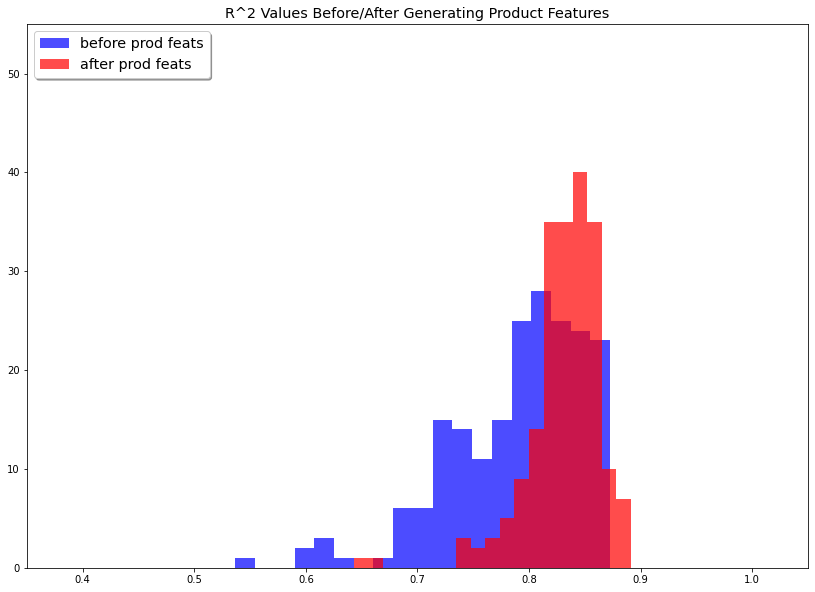

In [18]:
fig, ax = plt.subplots(figsize=(14, 10))
pd.Series(corr_r_sqs).hist(bins=19, color='blue', grid=False, label='before prod feats', alpha=0.7)
pd.Series(prod_r_sqs).hist(bins=19, color='red', grid=False, label='after prod feats', alpha=0.7)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlim(0.35, 1.05)
plt.ylim(0,55)
plt.title('R^2 Values Before/After Generating Product Features', fontsize='x-large')
plt.show()

In [14]:
np.mean(corr_r_sqs), np.std(corr_r_sqs)

(0.7897105813714679, 0.06069677221158237)

In [15]:
np.mean(prod_r_sqs), np.std(prod_r_sqs)

(0.8314993958925774, 0.033039150722946525)

We see from both the plot and the numbers above that the inclusion of the product features has both increased the mean `R^2` value, by about 5%, and halfed the standard deviation on unseen data. 

Even if we had not seen the 5% increase in the mean value, it still would have been beneficial to introduce the product features due to the decrease in the standard deviation. In particular, the predictions would have been made more consistent and precise when applied to different chunks of unseen data.

We are lucky in this case and get both improved accuracy and improved precision.

This begs the question: can we repreat this process of generating product features to further introduce non-linearity into the independent features and push up the mean `R^2` value and push down its standard deviation on unseen data?

Attempting to answer this question naïvely by immediately computing the set of all possible unique products of the current 202 features would involve computing 20,281 new columns of a dataframe. This is computationally much more complex than the original 32 numerical features. 

In [76]:
norm_prod_df = pd.read_csv('AmesHousing_FirstProductHighCorrNormNumFeatures.csv') # after creating product features
norm_prod_df.head()

,Kitchen AbvGr x Open Porch SF,Wood Deck SF,Bedroom AbvGr x Wood Deck SF,Wood Deck SF x Year Remod/Add,Wood Deck SF x Garage Yr Blt,Wood Deck SF x Year Built,Mas Vnr Area x Mas Vnr Area,Lot Area x Total Bsmt SF,Half Bath x Mas Vnr Area,Open Porch SF x Mas Vnr Area,...,Full Bath x Total Bsmt SF,Full Bath x Garage Area,Year Remod/Add x Gr Liv Area,Garage Area x Gr Liv Area,Garage Yr Blt x Gr Liv Area,1st Flr SF x Garage Cars,Year Built x Gr Liv Area,Total Bsmt SF x Garage Cars,Garage Cars x Gr Liv Area,Log SalePrice
0,0.036257,0.147472,0.073736,0.143803,0.143803,0.143803,0.004900,0.026090,0.00000,0.007614,...,0.044190,0.088710,0.286212,0.104150,0.286212,0.130010,0.286212,0.070704,0.117405,0.907194
1,0.000000,0.098315,0.032772,0.095918,0.095918,0.095918,0.000000,0.007794,0.00000,0.000000,...,0.036088,0.122648,0.154937,0.077910,0.154937,0.035172,0.154937,0.028871,0.031762,0.854242
2,0.021053,0.275983,0.137992,0.268843,0.268843,0.268843,0.004556,0.014417,0.03375,0.004263,...,0.054378,0.052419,0.229461,0.049391,0.229461,0.052169,0.229461,0.043502,0.047111,0.890707
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017905,0.00000,0.000000,...,0.172668,0.175403,0.366166,0.131195,0.366166,0.165653,0.366166,0.138134,0.149592,0.916543
4,0.019883,0.148876,0.074438,0.147988,0.147914,0.147914,0.000000,0.009759,0.00000,0.000000,...,0.075941,0.161962,0.287004,0.093526,0.286860,0.072856,0.286860,0.060753,0.115491,0.898022


In [77]:
norm_prod_cols = list(norm_prod_df.columns)

In [79]:
feat_pairs = list()
for feat_1 in norm_prod_cols:
    for feat_2 in norm_prod_cols:
        if [feat_1, feat_2] not in feat_pairs and [feat_2, feat_1] not in feat_pairs:
            feat_pairs.append([feat_1, feat_2])
            norm_prod_df[f'{feat_1} x {feat_2}'] = norm_prod_df[feat_1]*norm_prod_df[feat_2]
            
# turn this into a function: gen_prod_feats(df)

In [81]:
len(norm_prod_df.columns)

20281

In [ ]:
corr_thresh_min = 0.05

target_corr_dict = norm_prod_df.corr().iloc[:,-1].to_dict()
sort_target_corr = dict(sorted(target_corr_dict.items(), key=lambda item: np.abs(item[1])))
high_corr_feats = list({k: v for k,v in sort_target_corr.items() 
                   if np.abs(v) > corr_thresh_min and k != 'Log SalePrice'}.keys())

high_corr_df = norm_prod_df[high_corr_feats+['Log SalePrice']]

lin_reg = LinearRegression()
X, y = high_corr_df.iloc[:,:-1].values, high_corr_df.iloc[:,-1:].values
lin_reg.fit(X, y)
metrics = Metrics(X,y,lin_reg)
metrics.pretty_print_stats()